In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# STEP 1: Load the dataset
df = pd.read_csv("acc_gyr.csv")  # Change path if needed

# STEP 2: Compute vector norms for accelerometer and gyroscope
df['acc_norm'] = np.sqrt(df['xAcc']**2 + df['yAcc']**2 + df['zAcc']**2)
df['gyr_norm'] = np.sqrt(df['xGyro']**2 + df['yGyro']**2 + df['zGyro']**2)

# STEP 3: Simplify labels to "fall" or "nofall"
fall_keywords = ['fall', 'slip', 'collapse', 'trip']  # Customize if needed

def map_label(label):
    for word in fall_keywords:
        if word in label.lower():
            return 'fall'
    return 'nofall'

df['label'] = df['label'].apply(map_label)

# STEP 4: Keep only necessary columns
df_reduced = df[['acc_norm', 'gyr_norm', 'label']]

# STEP 5: Group every 400 rows into one sample
samples = len(df_reduced) // 400
X = []
y = []

for i in range(samples):
    chunk = df_reduced.iloc[i*400:(i+1)*400]

    acc_flat = chunk['acc_norm'].values  # 400 values
    gyr_flat = chunk['gyr_norm'].values  # 400 values

    # Combine into a single 800-length feature vector
    combined = np.concatenate((acc_flat, gyr_flat))
    X.append(combined)

    # Assume all 400 rows in the chunk have the same label (take first one)
    y.append(chunk['label'].values[0])

# STEP 6: Convert to numpy array and encode labels
X = np.array(X)
le = LabelEncoder()
y = le.fit_transform(y)  # fall → 1, nofall → 0

# Print shapes
print("X shape:", X.shape)
print("y shape:", y.shape)
print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))


X shape: (242, 800)
y shape: (242,)
Label mapping: {np.str_('fall'): np.int64(0), np.str_('nofall'): np.int64(1)}


In [ ]:
df_reduced.head(20)
df_reduced.to_csv('cleaned.csv')

In [ ]:
df_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96800 entries, 0 to 96799
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   acc_norm  96800 non-null  float64
 1   gyr_norm  96800 non-null  float64
 2   label     96800 non-null  object 
dtypes: float64(2), object(1)
memory usage: 2.2+ MB


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - accuracy: 0.6289 - loss: 16.4028 - val_accuracy: 0.8500 - val_loss: 2.6883
Epoch 2/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7271 - loss: 7.2954 - val_accuracy: 0.9000 - val_loss: 0.9602
Epoch 3/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7404 - loss: 7.7789 - val_accuracy: 0.9000 - val_loss: 2.4716
Epoch 4/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7910 - loss: 7.6935 - val_accuracy: 0.9000 - val_loss: 4.1115
Epoch 5/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8182 - loss: 3.4604 - val_accuracy: 0.8500 - val_loss: 1.7906
Epoch 6/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7563 - loss: 4.4323 - val_accuracy: 0.8500 - val_loss: 2.4765
Epoch 7/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8100 - loss: 2.6027 - val_accuracy: 0.9000 - val_loss: 2.1835
Epoch 8/30
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8392 - loss: 1.9359 - val_accuracy: 0.8500 - val_loss: 1

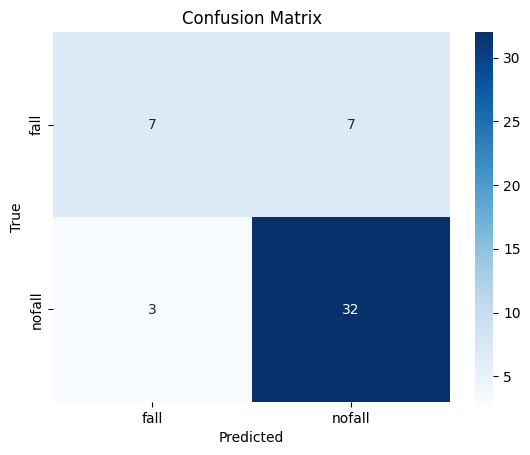

              precision    recall  f1-score   support

        fall       0.70      0.50      0.58        14
      nofall       0.82      0.91      0.86        35

    accuracy                           0.80        49
   macro avg       0.76      0.71      0.72        49
weighted avg       0.79      0.80      0.78        49



In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

# STEP 1: Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# STEP 2: One-hot encode labels (binary classification)
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

# STEP 3: Build the neural network model
model = Sequential([
    Dense(256, input_shape=(800,), activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')  # 2 output classes: fall, nofall
])

# STEP 4: Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# STEP 5: Train the model
history = model.fit(X_train, y_train_cat, epochs=30, batch_size=16, validation_split=0.1)

# STEP 6: Evaluate on test data
loss, accuracy = model.evaluate(X_test, y_test_cat)
print(f"Test Accuracy: {accuracy:.4f}")

# STEP 7: Confusion matrix
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['fall', 'nofall'], yticklabels=['fall', 'nofall'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, y_pred, target_names=['fall', 'nofall']))


In [ ]:
model.save('fall_detection_model.keras')

